<a href="https://colab.research.google.com/github/LuisIZ/Lab1_AnimalSound_DeepLearning/blob/test_model/notebooks/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 1 - Animal Sound

## Librerías

In [1]:
# Para redes neuronales
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Para visualización de resultados
import matplotlib.pyplot as plt

# Para procesamiento de audio
import torchaudio
import librosa
import librosa.display

# Para métricas
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Para manipulación de datos
import numpy as np
import pandas as pd

# Otros
import os
from pathlib import Path
import random
import math
from tqdm import tqdm
import csv
from google.colab import drive

In [2]:
# Libreria para decodificar audio en PyTorch tensors
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 44.2 MB/s eta 0:00:00


## GPU

In [3]:
!nvidia-smi

Mon Jan 19 23:18:28 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Seed

In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

## Análisis Exploratorio de Datos (EDA)

1. ¿Cuál es el objetivo del laboratorio?

Queremos desarrollar un modelo de clasificación multi-etiqueta que pueda identificar correctamente los animales presentes en las grabaciones de la selva amazónica.

2. ¿Qué tipo de datos tenemos en nuestro dataset?

Tenemos los archivos de audio en formato WAV en las carpetas `train/` y `test/`. Además, en la primera carpeta, tenemos un archivo CSV que tiene como primera columna el nombre del archivo o `filename` y el resto de columnas son los nombres de cada especie. En total son 43 columnas, la primera contendra strings mientras que el resto contendrá valores 0 o 1 que indican la ausencia o presencia de la especie en la grabación.

3. ¿Qué herramientas planeamos utilizar?

En principio, planeamos utilizar `PyTorch` para los modelos (para que utilicen redes neuronales), `Matplotlib` para crear los gráficos de nuestros resultados (ej. modelar el descenso de la gradiente o como va evolucionando los losses en la etapa de training y testing), `TorchAudio` o `Librosa` para analizar features del dataset (ej. Mel-spectogram, MFCC, etc.), `Sklearn` para obtener metricas (ej. f1 score, multilabel confusion matrix, ROC/PR curves etc.) y utilizar métodos de reducción de dimensionalidad (ej. PSA, TSNE, etc.), `Pandas` y `Numpy` para manipular la data y sacar alguna métricas estadísticas (ej. promedio, cuartiles, etc.).

4. ¿Qué restricciones tenemos?

Además del plazo de entrega que es de 1 semana, tenemos recursos computacionales limitados. Trabajaremos con Colab para aprovechar la GPU que nos brinda.

## Google Drive


Verificamos el acceso a Google Drive porque estamos desarrollando el laboratorio en VS Code con la extensión de Google Colab y desde la página web de este último para poder acceder sin problemas a la data en Google Drive que está como acceso directo (*symlink*) a una carpeta compartida.

In [5]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [6]:
MYDRIVE = Path("/content/drive/MyDrive")

hits = list(MYDRIVE.rglob("Animal Sounds"))
if not hits:
    raise FileNotFoundError("No encuentro la carpeta 'Animal Sounds' dentro de MyDrive. Revisa que el acceso directo exista.")

DATA_ROOT = hits[0]          # la ruta “atajo”
REAL_ROOT = hits[0].resolve() # la ruta real (como symlink)

print("DATA_ROOT:", DATA_ROOT)
print("REAL_ROOT:", REAL_ROOT)

DATA_ROOT: /content/drive/MyDrive/Animal Sounds
REAL_ROOT: /content/drive/.shortcut-targets-by-id/1F5_zs2zy0oECJu6NSwXtSAsIL9HQJ3yf/Animal Sounds


In [7]:
TRAIN_7Z  = REAL_ROOT / "train.7z"
TEST_7Z   = REAL_ROOT / "test.7z"
TRAIN_CSV = REAL_ROOT / "train.csv"

for p in [TRAIN_7Z, TEST_7Z, TRAIN_CSV]:
    print(p, "=>", p.exists())

/content/drive/.shortcut-targets-by-id/1F5_zs2zy0oECJu6NSwXtSAsIL9HQJ3yf/Animal Sounds/train.7z => True
/content/drive/.shortcut-targets-by-id/1F5_zs2zy0oECJu6NSwXtSAsIL9HQJ3yf/Animal Sounds/test.7z => True
/content/drive/.shortcut-targets-by-id/1F5_zs2zy0oECJu6NSwXtSAsIL9HQJ3yf/Animal Sounds/train.csv => True


Habiendo encontrado las rutas de nuestros archivos:

- La carpeta comprimida con los datos de training (`train.7z`)
- La carpeta comprimida con los datos de testing (`test.7z`)
- El archivo csv con las multi-etiquetas de cada video, indicando que especie suena en el audio, 1, y cual no, 0 (`train.csv`)

En la siguiente sección, procedemos a descomprimir las carpetas, utilizando la herramienta `7z`, y revisar su contenido para poder realizar el Análisis Exploratorio de Datos (o *EDA* por sus siglas en Inglés).

## Dataset

Como trabajar con los datos directamente en Drive sería muy lento, procederemos a guardar el contenido de los archivos descomprimidos en `/content` que es el disco local temporal de la máquina de Colab que ofrece mayor velocidad de I/O. Al ser temporal, si se reinicia el entorno, es necesario repetir la descompresión.

In [8]:
# Verificamos que haya suficiente espacio en /content
!df -h /content

Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   39G   74G  35% /


In [18]:
# Definimos rutas y creamos carpetas para guardar los datos
DRIVE_DATA = Path("/content/drive/.shortcut-targets-by-id/1F5_zs2zy0oECJu6NSwXtSAsIL9HQJ3yf/Animal Sounds")
TRAIN_7Z = DRIVE_DATA / "train.7z"
TEST_7Z  = DRIVE_DATA / "test.7z"
TRAIN_CSV = DRIVE_DATA / "train.csv"

OUT_BASE = Path("/content/data")
TRAIN_OUT = OUT_BASE / "train"
TEST_OUT  = OUT_BASE / "test"

TRAIN_OUT.mkdir(parents=True, exist_ok=True)
TEST_OUT.mkdir(parents=True, exist_ok=True)

print(TRAIN_7Z.exists(), TEST_7Z.exists(), TRAIN_CSV.exists())
print("Extracción a:", OUT_BASE)

True True True
Extracción a: /content/data


In [10]:
# Extraemos los datos
!7z x "/content/drive/.shortcut-targets-by-id/1F5_zs2zy0oECJu6NSwXtSAsIL9HQJ3yf/Animal Sounds/train.7z" -o"/content/data/train" -y
!7z x "/content/drive/.shortcut-targets-by-id/1F5_zs2zy0oECJu6NSwXtSAsIL9HQJ3yf/Animal Sounds/test.7z"  -o"/content/data/test"  -y


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/.shortcut-targe . wXtSAsIL9HQJ3yf/Animal Sounds/                                                                         1 file, 7069498436 bytes (6742 MiB)

Extracting archive: /content/drive/.shortcut-targets-by-id/1F5_zs2zy0oECJu6NSwXtSAsIL9HQJ3yf/Animal Sounds/train.7z
--
Path = /content/drive/.shortcut-targets-by-id/1F5_zs2zy0oECJu6NSwXtSAsIL9HQJ3yf/Animal Sounds/train.7z
Type = 7z
Physical Size = 7069498436
Headers Size = 727932
Method = LZMA2:23
Solid = +
Blocks = 1

  0%      0% - train/INCT17_20191113_040000_0_3.wav                 

In [15]:
# Verificamos si estan los audios
!find /content/data/train -maxdepth 2 -type f | head
!find /content/data/test  -maxdepth 2 -type f | head

/content/data/train/train/INCT17_20191113_040000_0_3.wav
/content/data/train/train/INCT17_20191113_040000_10_13.wav
/content/data/train/train/INCT17_20191113_040000_11_14.wav
/content/data/train/train/INCT17_20191113_040000_12_15.wav
/content/data/train/train/INCT17_20191113_040000_13_16.wav
/content/data/train/train/INCT17_20191113_040000_14_17.wav
/content/data/train/train/INCT17_20191113_040000_15_18.wav
/content/data/train/train/INCT17_20191113_040000_16_19.wav
/content/data/train/train/INCT17_20191113_040000_17_20.wav
/content/data/train/train/INCT17_20191113_040000_18_21.wav
/content/data/test/test/INCT17_20191125_040000_0_3.wav
/content/data/test/test/INCT17_20191125_040000_10_13.wav
/content/data/test/test/INCT17_20191125_040000_11_14.wav
/content/data/test/test/INCT17_20191125_040000_12_15.wav
/content/data/test/test/INCT17_20191125_040000_13_16.wav
/content/data/test/test/INCT17_20191125_040000_14_17.wav
/content/data/test/test/INCT17_20191125_040000_15_18.wav
/content/data/t

In [16]:
DATA_DIR = Path("/content/data")

def resolve_nested(split_dir: Path):
    nested = split_dir / split_dir.name
    return nested if nested.exists() else split_dir

TRAIN_DIR = resolve_nested(DATA_DIR / "train")
TEST_DIR  = resolve_nested(DATA_DIR / "test")

print("TRAIN_DIR:", TRAIN_DIR)
print("TEST_DIR :", TEST_DIR)
print("Ejemplo train existe:", TRAIN_DIR.exists())
print("Ejemplo test existe :", TEST_DIR.exists())

TRAIN_DIR: /content/data/train/train
TEST_DIR : /content/data/test/test
Ejemplo train existe: True
Ejemplo test existe : True


In [19]:
df = pd.read_csv(TRAIN_CSV)
print(df.shape)
df.head()

(62191, 43)


,filename,SPHSUR,BOABIS,SCIPER,DENNAH,LEPLAT,RHIICT,BOALEP,BOAFAB,PHYCUV,...,SCINAS,LEPNOT,ADEMAR,BOAALM,PHYDIS,RHIORN,LEPFLA,SCIRIZ,DENELE,SCIALT
0,INCT20955_20190909_050000_0_3.wav,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,INCT20955_20190909_050000_1_4.wav,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,INCT20955_20190909_050000_2_5.wav,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,INCT20955_20190909_050000_3_6.wav,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,INCT20955_20190909_050000_4_7.wav,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
f0 = df["filename"].iloc[0]
print("Archivo:", f0)
print("Existe?:", (TRAIN_DIR / f0).exists())

Archivo: INCT20955_20190909_050000_0_3.wav
Existe?: True


In [21]:
drive_root = Path("/content/drive")

train7z = list(drive_root.rglob("train.7z"))
test7z  = list(drive_root.rglob("test.7z"))
csvs    = list(drive_root.rglob("train.csv"))

print("train.7z encontrados:", len(train7z))
print("test.7z encontrados:", len(test7z))
print("train.csv encontrados:", len(csvs))

# candidato: carpeta que tenga los 3 archivos
candidates = []
for p in train7z:
    folder = p.parent
    if (folder / "test.7z").exists() and (folder / "train.csv").exists():
        candidates.append(folder)

print("Carpetas candidatas:", len(candidates))
for c in candidates[:10]:
    print(" -", c)

DATASET_DIR = candidates[0]  # si sale >1, elegimos la que corresponde
print("Usando DATASET_DIR:", DATASET_DIR)

train.7z encontrados: 1
test.7z encontrados: 1
train.csv encontrados: 1
Carpetas candidatas: 1
 - /content/drive/.shortcut-targets-by-id/1F5_zs2zy0oECJu6NSwXtSAsIL9HQJ3yf/Animal Sounds
Usando DATASET_DIR: /content/drive/.shortcut-targets-by-id/1F5_zs2zy0oECJu6NSwXtSAsIL9HQJ3yf/Animal Sounds


## EDA

### Labels

In [16]:
label_cols = df.columns[1:]   # las columnas de todas las especies en un audio
Y = df[label_cols].astype(int)

k = Y.sum(axis=1)
print("Shape:", df.shape)
print("Num audios:", len(df))
print("Num clases:", len(label_cols))
print("Audios únicos:", df["filename"].nunique())
print("Nulos totales:", df.isna().sum().sum())
print("Porcentaje audios sin etiquetas:", (k==0).mean()*100)

Shape: (62191, 43)
Num audios: 62191
Num clases: 42
Audios únicos: 62191
Nulos totales: 0
Porcentaje audios sin etiquetas: 36.18530012381213


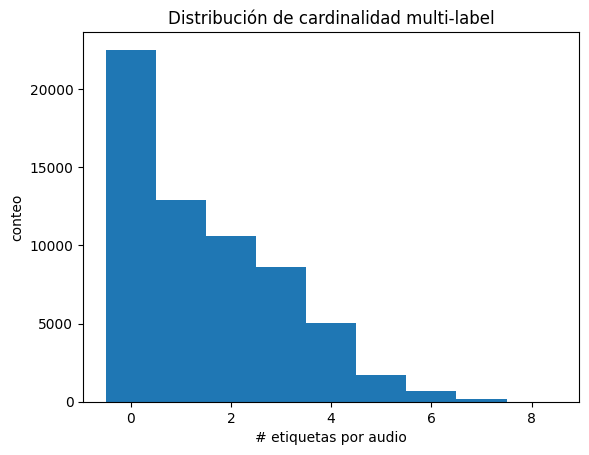

In [17]:
plt.figure()
plt.hist(k, bins=np.arange(k.max()+2)-0.5)
plt.xlabel("# etiquetas por audio")
plt.ylabel("conteo")
plt.title("Distribución de cardinalidad multi-label")
plt.show()

In [18]:
# ¿cuántas etiquetas por audio?
k = df[label_cols].sum(axis=1)
k.describe()

,0
count,62191.000000
mean,1.509463
std,1.539720
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,8.000000


In [19]:
# balance por clase
class_counts = Y.sum().sort_values(ascending=False)
print("Top 10 clases:\n", class_counts.head(10))
print("\nBottom 10 clases:\n", class_counts.tail(10))

Top 10 clases:
 SPHSUR    13258
BOABIS    10888
BOAFAB     6438
DENMIN     6070
LEPPOD     6032
PHYALB     5374
LEPLAT     5244
PITAZU     4873
PHYCUV     4240
DENNAN     3801
dtype: int64

Bottom 10 clases:
 PHYMAR    200
DENELE    149
SCIRIZ     73
AMEPIC     68
LEPELE     34
RHIORN     21
RHISCI     11
LEPFLA      7
SCIFUS      0
SCINAS      0
dtype: int64


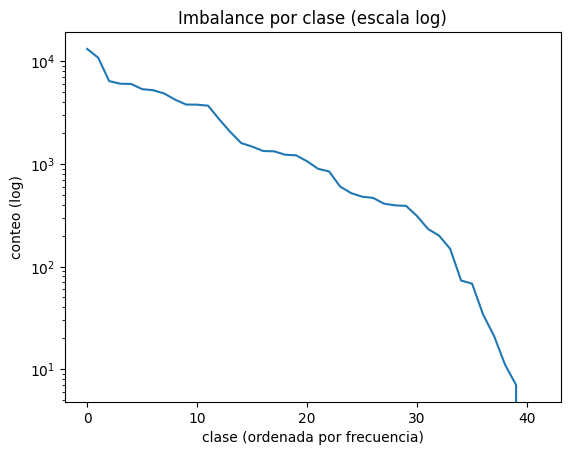

In [20]:
plt.figure()
plt.plot(class_counts.values)
plt.yscale("log")
plt.xlabel("clase (ordenada por frecuencia)")
plt.ylabel("conteo (log)")
plt.title("Imbalance por clase (escala log)")
plt.show()

In [21]:
# porcentaje de precensia por clase
class_pct = (class_counts / len(df) * 100).sort_values(ascending=False)
class_pct.head(10)

,0
SPHSUR,21.318197
BOABIS,17.507356
BOAFAB,10.351980
DENMIN,9.760255
LEPPOD,9.699153
PHYALB,8.641122
LEPLAT,8.432088
PITAZU,7.835539
PHYCUV,6.817707
DENNAN,6.111817


In [22]:
# clases con 0 o muy pocas apariciones
zero_classes = class_counts[class_counts==0].index.tolist()
rare_classes = class_counts[class_counts<100].index.tolist()
print("Clases con 0 en train:", zero_classes)
print("Clases con <100 en train:", len(rare_classes))

Clases con 0 en train: ['SCIFUS', 'SCINAS']
Clases con <100 en train: 8


### Co-ocurrencias

In [23]:
# matriz co-ocurrencia (42x42)
cooc = (Y.T @ Y).astype(int)
np.fill_diagonal(cooc.values, 0)

# top pares
pairs = []
for i, a in enumerate(label_cols):
    for j, b in enumerate(label_cols):
        if j <= i:
            continue
        c = cooc.loc[a, b]
        if c > 0:
            pairs.append((c, a, b))
pairs.sort(reverse=True)

print("Top 15 pares más comunes:")
for c,a,b in pairs[:15]:
    print(f"{a} + {b}: {c}")

Top 15 pares más comunes:
SPHSUR + BOABIS: 8582
SPHSUR + LEPLAT: 4540
BOABIS + LEPLAT: 3891
SPHSUR + BOAFAB: 3566
SPHSUR + SCIPER: 3198
DENMIN + LEPPOD: 2602
PHYALB + LEPPOD: 2532
DENMIN + DENNAN: 2532
BOABIS + SCIPER: 2346
PITAZU + LEPPOD: 2247
DENMIN + PITAZU: 2181
DENMIN + PHYALB: 2024
DENMIN + SCIFUV: 1990
DENNAN + PHYALB: 1869
PITAZU + PHYALB: 1791


### Audio

In [24]:
def audio_info_fast(path):
    waveform, sample_rate = torchaudio.load(str(path))
    num_channels = waveform.shape[0]
    num_frames = waveform.shape[1]
    duration = num_frames / sample_rate
    return sample_rate, num_frames, duration, num_channels

In [25]:
sample_n = 1000
sample_files = df["filename"].sample(sample_n, random_state=SEED).tolist()

In [26]:
srs, durs, chs = [], [], []
for fn in tqdm(sample_files):
    p = TRAIN_DIR / fn
    sr, nframes, dur, nch = audio_info_fast(p)
    srs.append(sr); durs.append(dur); chs.append(nch)

100%|██████████| 1000/1000 [00:19<00:00, 50.79it/s]


In [27]:
print("Sample rate (valores únicos aprox):", sorted(set(srs))[:10], "...")
print("Canales (valores únicos):", sorted(set(chs)))
print("Duración promedio:", np.mean(durs), "sec")
print("Duración min/max:", np.min(durs), np.max(durs))

Sample rate (valores únicos aprox): [22050] ...
Canales (valores únicos): [1]
Duración promedio: 3.0 sec
Duración min/max: 3.0 3.0


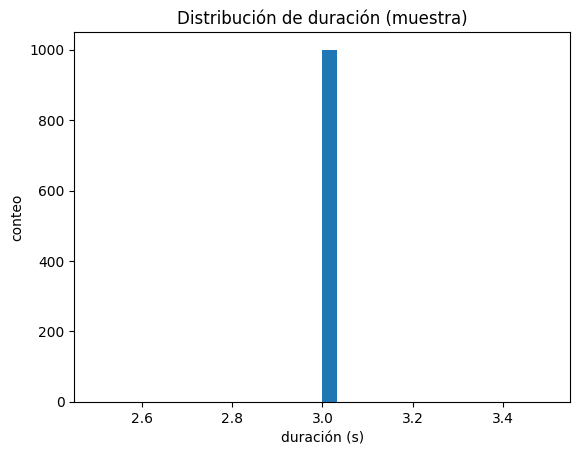

In [28]:
plt.figure()
plt.hist(durs, bins=30)
plt.xlabel("duración (s)")
plt.ylabel("conteo")
plt.title("Distribución de duración (muestra)")
plt.show()

In [29]:
def plot_wave_and_melspec(wav_path, target_sr=22050):
    y, sr = librosa.load(wav_path, sr=target_sr, mono=True)
    plt.figure()
    plt.plot(y)
    plt.title(f"Waveform | sr={sr} | len={len(y)/sr:.2f}s")
    plt.show()

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=1024, hop_length=512)
    S_db = librosa.power_to_db(S, ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format="%+2.0f dB")
    plt.title("Log-Mel Spectrogram")
    plt.show()

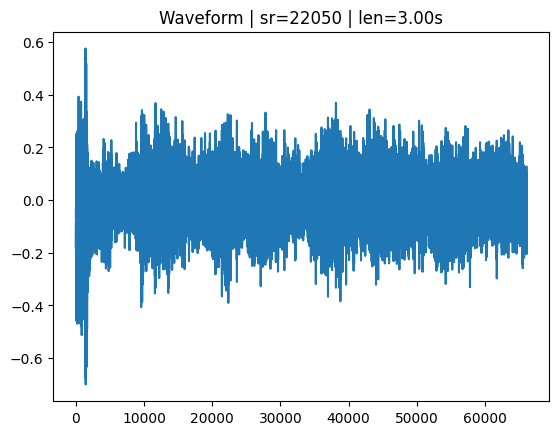

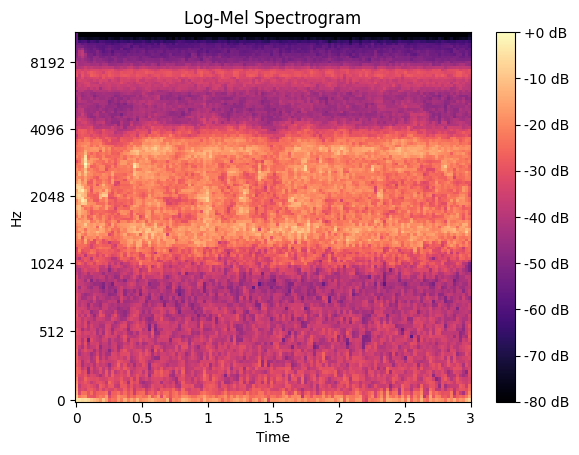

In [30]:
# ejemplo: uno random
fn = df["filename"].iloc[0]
plot_wave_and_melspec(str(TRAIN_DIR/fn))

## Feature Extraction

In [37]:
# creamos carpeta para almacenar features
CACHE_DIR = Path("/content/drive/MyDrive/Lab1_cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
print(CACHE_DIR)

/content/drive/MyDrive/Lab1_cache


In [38]:
def extract_mfcc_stats(wav_path, target_sr=22050, n_mfcc=20):
    # Cargamos sin forzar sr para respetar el original
    y, sr = librosa.load(wav_path, sr=None, mono=True)

    # Resample SOLO si fuera necesario (según tu EDA, siempre será 22050)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # stats (baseline)
    feat = np.concatenate([mfcc.mean(axis=1), mfcc.std(axis=1)]).astype(np.float32)
    return feat

In [39]:
n_mfcc = 20
feat_names = [f"mfcc_mean_{i}" for i in range(n_mfcc)] + [f"mfcc_std_{i}" for i in range(n_mfcc)]

In [40]:
# =========================
# CONFIG
# =========================
CACHE_DIR = Path("/content/drive/MyDrive/Lab1_cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

H5_PATH = CACHE_DIR / "train_mfcc_stats.h5"
KEY = "train"
BATCH = 256  # ¿probar 256 o 512?

# para evitar el error de "string len limit"
MIN_ITEMSIZE = {"filename": 120}

# =========================
# (OPCIONAL) LIMPIAR H5 SI ESTÁ "MAL CREADO"
# =========================
# Si sale el error de itemsize, lo más limpio es borrar y regenerar
if H5_PATH.exists():
    print("H5 ya existe:", H5_PATH)
    print("Si este archivo fue creado antes SIN min_itemsize, podría fallar. "
          "Si vuelve a fallar, bórralo (os.remove) y reintenta.")
    # Descomentar si se quiere forzar recreación
    # os.remove(H5_PATH)

# =========================
# RECUPERAR PROCESADOS
# =========================
processed = set()
if H5_PATH.exists():
    try:
        with pd.HDFStore(H5_PATH, mode="r") as store:
            if f"/{KEY}" in store.keys():
                processed = set(store.select(KEY, columns=["filename"])["filename"].astype(str).tolist())
    except Exception as e:
        print("No se pudo leer el H5 para resume. Error:", repr(e))
        print("Recomendación: borrar el H5 y regenerar.")
        # os.remove(H5_PATH)
        processed = set()

print("Procesados previamente:", len(processed))

# =========================
# EXTRACCIÓN + GUARDADO POR BATCH
# =========================
rows = []
skipped_missing = 0
skipped_errors = 0
written = 0

for i in tqdm(range(len(df)), desc="Extrayendo MFCC"):
    fn = str(df.loc[i, "filename"])

    if fn in processed:
        continue

    wav_path = TRAIN_DIR / fn
    if not wav_path.exists():
        skipped_missing += 1
        continue

    try:
        feat = extract_mfcc_stats(str(wav_path), target_sr=22050, n_mfcc=n_mfcc)
    except Exception:
        skipped_errors += 1
        continue

    row = {"filename": fn}
    row.update({k: float(v) for k, v in zip(feat_names, feat)})

    for c in label_cols:
        row[c] = int(df.loc[i, c])

    rows.append(row)

    # flush por batch
    if len(rows) >= BATCH:
        out = pd.DataFrame(rows)

        # Guardar (con min_itemsize para filename)
        out.to_hdf(
            H5_PATH,
            key=KEY,
            mode="a",
            format="table",
            append=True,
            data_columns=["filename"],
            min_itemsize=MIN_ITEMSIZE,
            complib="blosc",
            complevel=5
        )

        written += len(out)
        rows = []

# flush final
if rows:
    out = pd.DataFrame(rows)
    out.to_hdf(
        H5_PATH,
        key=KEY,
        mode="a",
        format="table",
        append=True,
        data_columns=["filename"],
        min_itemsize=MIN_ITEMSIZE,
        complib="blosc",
        complevel=5
    )
    written += len(out)

print("Listo. Guardado en:", H5_PATH)
print("Escritos nuevos:", written)
print("Saltados (faltan archivos):", skipped_missing)
print("Saltados (errores lectura/audio):", skipped_errors)

H5 ya existe: /content/drive/MyDrive/Lab1_cache/train_mfcc_stats.h5
Si este archivo fue creado antes SIN min_itemsize, podría fallar. Si vuelve a fallar, bórralo (os.remove) y reintenta.
Procesados previamente: 62191


Extrayendo MFCC: 100%|██████████| 62191/62191 [00:00<00:00, 144562.72it/s]

Listo. Guardado en: /content/drive/MyDrive/Lab1_cache/train_mfcc_stats.h5
Escritos nuevos: 0
Saltados (faltan archivos): 0
Saltados (errores lectura/audio): 0


In [35]:
"""
# OJO: Solo correrlo si necesitas volver a extraer y guardar los features
CACHE_DIR = Path("/content/drive/MyDrive/Lab1_cache")
H5_PATH = CACHE_DIR / "train_mfcc_stats.h5"

if H5_PATH.exists():
    os.remove(H5_PATH)
    print("Borrado:", H5_PATH)
else:
    print("No existe aún:", H5_PATH)
"""

'\n# OJO: Solo correrlo si necesitas volver a extraer y guardar los features\nCACHE_DIR = Path("/content/drive/MyDrive/Lab1_cache")\nH5_PATH = CACHE_DIR / "train_mfcc_stats.h5"\n\nif H5_PATH.exists():\n    os.remove(H5_PATH)\n    print("Borrado:", H5_PATH)\nelse:\n    print("No existe aún:", H5_PATH)\n'

In [41]:
SAMPLE_N = 300
sample_files = df["filename"].sample(SAMPLE_N, random_state=42).tolist()
wav_paths = [str(TRAIN_DIR / f) for f in sample_files]

In [42]:
H5_PATH = "/content/drive/MyDrive/Lab1_cache/train_mfcc_stats.h5"
df_feat = pd.read_hdf(H5_PATH, key="train")

print("Shape:", df_feat.shape)
print("Cols:", df_feat.columns[:10].tolist())
print("Filenames únicos:", df_feat["filename"].nunique())
print("Nulos totales:", df_feat.isna().sum().sum())

df_feat.head()

Shape: (62191, 83)
Cols: ['filename', 'mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8']
Filenames únicos: 62191
Nulos totales: 0


,filename,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,...,SCINAS,LEPNOT,ADEMAR,BOAALM,PHYDIS,RHIORN,LEPFLA,SCIRIZ,DENELE,SCIALT
0,INCT20955_20190909_050000_0_3.wav,-133.729752,43.681675,-99.749802,45.028488,16.786245,30.951143,-4.702462,24.455971,-45.253811,...,0,0,0,0,0,0,0,0,0,0
1,INCT20955_20190909_050000_1_4.wav,-132.364273,43.140511,-99.892624,45.547062,15.306004,31.458197,-3.702340,23.289583,-44.638145,...,0,0,0,0,0,0,0,0,0,0
2,INCT20955_20190909_050000_2_5.wav,-136.289795,42.555725,-99.240761,44.990807,16.429117,30.860437,-2.081476,22.945210,-43.648701,...,0,0,0,0,0,0,0,0,0,0
3,INCT20955_20190909_050000_3_6.wav,-129.223923,42.070469,-102.566887,44.342339,16.269958,32.092392,-3.648416,24.171858,-43.824066,...,0,0,0,0,0,0,0,0,0,0
4,INCT20955_20190909_050000_4_7.wav,-125.102104,41.334099,-100.274544,42.715092,18.768997,30.813423,-2.192364,24.806515,-42.704868,...,0,0,0,0,0,0,0,0,0,0


## Models: Training

### 1) MFCC(mean/std) + MLP



In [23]:
!ls -lah /content/drive/MyDrive
!ls -lah /content/drive/MyDrive/Lab1_cache

total 3.0G
-rw-------  1 root root  181 Oct 16  2020 '1.01_1_Izaguirre Chiotti_ABP-M1.gslides'
-rw-------  1 root root 589K Apr  7  2022  1_13.xlsx
drwx------  7 root root 4.0K Aug 15  2022  2022-2
-rw-------  1 root root 3.2M May 29  2025 '2024_1.9. Meta_XR_SDK_Building Blocks Multiplayer-1.docx.pdf'
-rw-------  1 root root  21K Mar  9  2024 '2928578 (1).jpg'
-rw-------  1 root root  21K Mar  9  2024  2928578.jpg
-rw-------  1 root root  43K Oct 30  2024  3c6fb1c2-4e8e-4fcd-bbcc-518351368d62.jpeg
-rw-------  1 root root 493K May 12  2022  4.0.wav
-rw-------  1 root root 481K May 12  2022  4.1.wav
-rw-------  1 root root 477K May 12  2022  4.2.wav
-rw-------  1 root root 483K May 12  2022  4.3.wav
-rw-------  1 root root 487K May 12  2022  4.4.wav
-rw-------  1 root root 495K May 12  2022  6.0.wav
-rw-------  1 root root 495K May 12  2022  6.1.wav
-rw-------  1 root root 505K May 12  2022  6.2.wav
-rw-------  1 root root 501K May 12  2022  6.3.wav
-rw-------  1 root root 497K May 12  2

In [24]:
cands = list(Path("/content/drive").rglob("train_mfcc_stats.h5"))
print("Encontrados:", len(cands))
for p in cands[:20]:
    print(p)

Encontrados: 1
/content/drive/MyDrive/Lab1_cache/train_mfcc_stats.h5


In [25]:
CACHE_DIR = Path("/content/drive/MyDrive/Lab1_cache")
H5_PATH = CACHE_DIR / "train_mfcc_stats.h5"

assert H5_PATH.exists(), f"No encuentro: {H5_PATH}"

# mira qué keys tiene el HDF5 (para no fallar con el key)
with pd.HDFStore(H5_PATH, mode="r") as store:
    print("Keys:", store.keys())

df_feat = pd.read_hdf(H5_PATH, key="train")  # o el key que veas arriba
print(df_feat.shape)
df_feat.head()

Keys: ['/train']
(62191, 83)


,filename,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,...,SCINAS,LEPNOT,ADEMAR,BOAALM,PHYDIS,RHIORN,LEPFLA,SCIRIZ,DENELE,SCIALT
0,INCT20955_20190909_050000_0_3.wav,-133.729752,43.681675,-99.749802,45.028488,16.786245,30.951143,-4.702462,24.455971,-45.253811,...,0,0,0,0,0,0,0,0,0,0
1,INCT20955_20190909_050000_1_4.wav,-132.364273,43.140511,-99.892624,45.547062,15.306004,31.458197,-3.702340,23.289583,-44.638145,...,0,0,0,0,0,0,0,0,0,0
2,INCT20955_20190909_050000_2_5.wav,-136.289795,42.555725,-99.240761,44.990807,16.429117,30.860437,-2.081476,22.945210,-43.648701,...,0,0,0,0,0,0,0,0,0,0
3,INCT20955_20190909_050000_3_6.wav,-129.223923,42.070469,-102.566887,44.342339,16.269958,32.092392,-3.648416,24.171858,-43.824066,...,0,0,0,0,0,0,0,0,0,0
4,INCT20955_20190909_050000_4_7.wav,-125.102104,41.334099,-100.274544,42.715092,18.768997,30.813423,-2.192364,24.806515,-42.704868,...,0,0,0,0,0,0,0,0,0,0


In [26]:
CACHE_DIR = Path("/content/drive/MyDrive/Lab1_cache")
H5_PATH   = CACHE_DIR / "train_mfcc_stats.h5"
KEY       = "train"

df_feat = pd.read_hdf(H5_PATH, key=KEY)
print("Shape features:", df_feat.shape)
print(df_feat.head(2))

Shape features: (62191, 83)
                            filename  mfcc_mean_0  mfcc_mean_1  mfcc_mean_2  \
0  INCT20955_20190909_050000_0_3.wav  -133.729752    43.681675   -99.749802   
1  INCT20955_20190909_050000_1_4.wav  -132.364273    43.140511   -99.892624   

   mfcc_mean_3  mfcc_mean_4  mfcc_mean_5  mfcc_mean_6  mfcc_mean_7  \
0    45.028488    16.786245    30.951143    -4.702462    24.455971   
1    45.547062    15.306004    31.458197    -3.702340    23.289583   

   mfcc_mean_8  ...  SCINAS  LEPNOT  ADEMAR  BOAALM  PHYDIS  RHIORN  LEPFLA  \
0   -45.253811  ...       0       0       0       0       0       0       0   
1   -44.638145  ...       0       0       0       0       0       0       0   

   SCIRIZ  DENELE  SCIALT  
0       0       0       0  
1       0       0       0  

[2 rows x 83 columns]


In [27]:
label_cols = df.columns[1:].tolist()  # orden oficial de Kaggle

# features (X): solo MFCC stats
feat_names = [c for c in df_feat.columns if c.startswith("mfcc_mean_") or c.startswith("mfcc_std_")]

# sanity checks
missing = [c for c in label_cols if c not in df_feat.columns]
if missing:
    raise ValueError(f"Faltan estas columnas de labels en df_feat: {missing[:10]} ... (total {len(missing)})")

print("Num feats:", len(feat_names))
print("Num labels:", len(label_cols))

Num feats: 40
Num labels: 42


In [28]:
X = df_feat[feat_names].values.astype(np.float32)
y = df_feat[label_cols].values.astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_dl = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)),
                      batch_size=512, shuffle=True)
val_dl   = DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(y_val)),
                      batch_size=1024, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim),
        )
    def forward(self, x):
        return self.net(x)

model = MLP(X.shape[1], y.shape[1]).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# ===== pos_weight (Cambio 5) =====
pos = y_train.sum(axis=0)
neg = y_train.shape[0] - pos
pos_weight = neg / (pos + 1e-6)

# Para clases con 0 positivos, pos_weight se vuelve enorme -> clamp
pos_weight = np.clip(pos_weight, 1.0, 20.0)

crit = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight, device=device))

def eval_model(th=0.5):
    model.eval()
    all_pred, all_true = [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            prob = torch.sigmoid(model(xb)).cpu().numpy()
            all_pred.append(prob)
            all_true.append(yb.cpu().numpy())

    P = np.vstack(all_pred)
    T = np.vstack(all_true)
    Yhat = (P >= th).astype(int)

    micro = f1_score(T, Yhat, average="micro", zero_division=0)
    macro_all = f1_score(T, Yhat, average="macro", zero_division=0)

    # Macro más interpretable: excluye clases sin positivos en la validación
    mask = (T.sum(axis=0) > 0)
    macro_nonzero = f1_score(T[:, mask], Yhat[:, mask], average="macro", zero_division=0) if mask.any() else 0.0

    return micro, macro_all, macro_nonzero

for epoch in range(1, 6):
    model.train()
    total_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward()
        opt.step()
        total_loss += loss.item() * xb.size(0)

    micro, macro_all, macro_nonzero = eval_model(th=0.5)
    print(f"Epoch {epoch} | loss={total_loss/len(train_dl.dataset):.4f} | "
          f"F1 micro={micro:.4f} | F1 macro(all)={macro_all:.4f} | F1 macro(nonzero)={macro_nonzero:.4f}")

Device: cuda
Epoch 1 | loss=0.4978 | F1 micro=0.5179 | F1 macro(all)=0.3316 | F1 macro(nonzero)=0.3482
Epoch 2 | loss=0.2644 | F1 micro=0.5729 | F1 macro(all)=0.3860 | F1 macro(nonzero)=0.4053
Epoch 3 | loss=0.2215 | F1 micro=0.6163 | F1 macro(all)=0.4360 | F1 macro(nonzero)=0.4578
Epoch 4 | loss=0.1968 | F1 micro=0.6308 | F1 macro(all)=0.4774 | F1 macro(nonzero)=0.5013
Epoch 5 | loss=0.1805 | F1 micro=0.6401 | F1 macro(all)=0.5117 | F1 macro(nonzero)=0.5373


In [29]:
def get_probs(model, dl, device):
    model.eval()
    probs_list, true_list = [], []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(device)
            prob = torch.sigmoid(model(xb)).cpu().numpy()
            probs_list.append(prob)
            true_list.append(yb.numpy())
    return np.vstack(probs_list), np.vstack(true_list)

In [30]:
def tune_thresholds_macro_f1(P, T, grid=None):
    """
    P: probs (N,C)
    T: true  (N,C) binario
    Retorna thresholds (C,) que maximizan Macro F1 por clase.
    """
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)

    C = T.shape[1]
    thr = np.full(C, 0.5, dtype=np.float32)

    for c in range(C):
        # Si en validación no hay positivos para esa clase, no tiene sentido tunear.
        # Ponemos umbral 1.0 para evitar predecirla (mejor que adivinar).
        if T[:, c].sum() == 0:
            thr[c] = 1.0
            continue

        best_f1, best_t = -1.0, 0.5
        for t in grid:
            pred = (P[:, c] >= t).astype(int)
            f1 = f1_score(T[:, c], pred, zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        thr[c] = best_t

    return thr

In [31]:
# 1) probs/true de validación
P_val, T_val = get_probs(model, val_dl, device)

In [32]:
# 2) tunear thresholds
thresholds = tune_thresholds_macro_f1(P_val, T_val)

In [33]:
# 3) evaluar macro con thresholds
Yhat = (P_val >= thresholds[None, :]).astype(int)
macro_all = f1_score(T_val, Yhat, average="macro", zero_division=0)

mask = (T_val.sum(axis=0) > 0)
macro_nonzero = f1_score(T_val[:, mask], Yhat[:, mask], average="macro", zero_division=0) if mask.any() else 0.0

print("Macro F1 (all):", macro_all)
print("Macro F1 (nonzero):", macro_nonzero)
print("Ejemplo thresholds (primeras 10):", thresholds[:10])

Macro F1 (all): 0.6659713639788134
Macro F1 (nonzero): 0.699269932177754
Ejemplo thresholds (primeras 10): [0.8  0.8  0.9  0.95 0.85 0.85 0.8  0.85 0.75 0.85]


## Models: Testing and CSV Kaggle results

### 1) MFCC(mean/std) + MLP

In [49]:
from pathlib import Path

# ===== Puente: asegurar variables críticas =====

# 1) TEST_DIR
if "TEST_DIR" not in globals():
    # intenta recuperar desde tus variables típicas
    try:
        TEST_DIR = Path(TEST_OUT) / "test" if (Path(TEST_OUT) / "test").exists() else Path(TEST_OUT)
    except Exception:
        raise NameError("TEST_DIR no está definido. Ejecuta primero las celdas de extracción/rutas.")

print("TEST_DIR =", TEST_DIR)

# 2) label_cols (orden oficial)
if "label_cols" not in globals():
    if "df" in globals():
        label_cols = df.columns[1:].tolist()
    else:
        raise NameError("label_cols no está definido porque df no existe. Ejecuta primero la carga de train.csv.")

print("Num labels:", len(label_cols))

# 3) thresholds
if "thresholds" not in globals():
    raise NameError("thresholds no está definido. Ejecuta primero la celda de tuning de thresholds (validación).")

print("thresholds shape:", thresholds.shape)

# 4) model, feat_names
for v in ["model", "feat_names", "extract_mfcc_stats", "n_mfcc", "device"]:
    if v not in globals():
        raise NameError(f"Falta '{v}'. Ejecuta primero Feature Extraction y Model training.")
print("OK: variables listas para submission.")

TEST_DIR = /content/data/test/test
Num labels: 42
thresholds shape: (42,)
OK: variables listas para submission.


In [50]:
test_files = sorted([p.name for p in TEST_DIR.rglob("*.wav")])
print(test_files[:10])

['INCT17_20191125_040000_0_3.wav', 'INCT17_20191125_040000_10_13.wav', 'INCT17_20191125_040000_11_14.wav', 'INCT17_20191125_040000_12_15.wav', 'INCT17_20191125_040000_13_16.wav', 'INCT17_20191125_040000_14_17.wav', 'INCT17_20191125_040000_15_18.wav', 'INCT17_20191125_040000_16_19.wav', 'INCT17_20191125_040000_17_20.wav', 'INCT17_20191125_040000_18_21.wav']


In [51]:
print("TEST_DIR existe?", "TEST_DIR" in globals())
print("df existe?", "df" in globals())
print("label_cols:", len(label_cols) if "label_cols" in globals() else None)
print("feat_names:", len(feat_names) if "feat_names" in globals() else None)
print("thresholds:", thresholds.shape if "thresholds" in globals() else None)
print("model existe?", "model" in globals())

TEST_DIR existe? True
df existe? True
label_cols: 42
feat_names: 40
thresholds: (42,)
model existe? True


In [52]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import csv
from tqdm import tqdm

# --- Asegúrate de que estos existan en tu notebook ---
# TEST_DIR, extract_mfcc_stats, n_mfcc, feat_names, model, device, thresholds, label_cols

# 0) Sanity checks (esto te evita bugs raros)
assert len(label_cols) == 42, f"label_cols debería tener 42 clases y tiene {len(label_cols)}"
assert thresholds.shape[0] == 42, f"thresholds debería ser (42,) y es {thresholds.shape}"

# 1) Listar archivos test
test_files = sorted([p.name for p in TEST_DIR.rglob("*.wav")])
print("Test audios:", len(test_files), "| ejemplo:", test_files[:3])

# 2) Extraer MFCC stats para test
rows = []
for fn in tqdm(test_files, desc="Extrayendo MFCC (test)"):
    wav_path = TEST_DIR / fn
    feat = extract_mfcc_stats(str(wav_path), target_sr=22050, n_mfcc=n_mfcc)

    row = {"filename": fn}
    row.update({k: float(v) for k, v in zip(feat_names, feat)})
    rows.append(row)

df_test_feat = pd.DataFrame(rows)
print("df_test_feat:", df_test_feat.shape)

# 3) Inferencia en test
X_test = df_test_feat[feat_names].values.astype(np.float32)

model.eval()
with torch.no_grad():
    probs_test = torch.sigmoid(model(torch.tensor(X_test, device=device))).cpu().numpy()

assert probs_test.shape[1] == 42, f"Tu modelo debería devolver 42 outputs y devuelve {probs_test.shape[1]}"

# 4) probs -> "1 5 7" (SIEMPRE espacio, NUNCA coma)
def probs_to_pred_str(prob_row, thr):
    active = np.where(prob_row >= thr)[0] + 1  # +1 para 1..42
    active = active[(active >= 1) & (active <= 42)]
    if active.size == 0:
        return "0"
    return " ".join(map(str, active.tolist()))

pred_str = [probs_to_pred_str(probs_test[i], thresholds) for i in range(len(probs_test))]

# 5) Id = nombre del archivo SIN .wav (sin cortar nada)
ids = [Path(fn).stem for fn in df_test_feat["filename"].tolist()]

sub = pd.DataFrame({"Id": ids, "Predicted": pred_str})

# 6) Validaciones IMPORTANTES antes de guardar
print("Columnas:", sub.columns.tolist())
assert sub.shape[1] == 2, "El submission debe tener EXACTAMENTE 2 columnas: Id y Predicted"
assert sub["Id"].str.contains(r"\.wav$", regex=True).sum() == 0, "Id no debe incluir .wav"

# Predicted: sin comas y dentro de 1..42
bad_commas = sub["Predicted"].str.contains(",", regex=False).sum()
print("Filas con coma en Predicted:", bad_commas)
assert bad_commas == 0, "Predicted NO debe contener comas. Debe separar con espacios."

def max_index(s):
    if s == "0":
        return 0
    return max(map(int, s.split()))

mx = sub["Predicted"].map(max_index).max()
print("Máximo índice en Predicted:", mx)
assert mx <= 42, f"Hay índices > 42 en Predicted (máximo={mx}). Eso está mal."

print(sub.head(5))

# 7) Guardar con nombre claro del modelo 1
MODEL_TAG = "model1_mfcc_mlp"
sub_path = Path(f"/content/drive/MyDrive/Lab1_cache/submission_{MODEL_TAG}.csv")

# QUOTE_ALL ayuda a que Excel no “parta” el campo Predicted
sub.to_csv(sub_path, index=False, quoting=csv.QUOTE_ALL)

print("Guardado:", sub_path)

# 8) (Opcional) ver primeras líneas RAW del csv para confirmar formato
with open(sub_path, "r", encoding="utf-8") as f:
    for _ in range(5):
        print(f.readline().strip())

Test audios: 31187 | ejemplo: ['INCT17_20191125_040000_0_3.wav', 'INCT17_20191125_040000_10_13.wav', 'INCT17_20191125_040000_11_14.wav']


Extrayendo MFCC (test): 100%|██████████| 31187/31187 [05:22<00:00, 96.69it/s] 


df_test_feat: (31187, 41)
Columnas: ['Id', 'Predicted']
Filas con coma en Predicted: 0
Máximo índice en Predicted: 42
                             Id Predicted
0    INCT17_20191125_040000_0_3        27
1  INCT17_20191125_040000_10_13         0
2  INCT17_20191125_040000_11_14         0
3  INCT17_20191125_040000_12_15         0
4  INCT17_20191125_040000_13_16         0
Guardado: /content/drive/MyDrive/Lab1_cache/submission_model1_mfcc_mlp.csv
"Id","Predicted"
"INCT17_20191125_040000_0_3","27"
"INCT17_20191125_040000_10_13","0"
"INCT17_20191125_040000_11_14","0"
"INCT17_20191125_040000_12_15","0"


In [53]:
print(sub.head(5))
print("Columnas:", sub.columns.tolist())

# verifica que Predicted NO tenga comas y que max índice <= 42
bad_commas = sub["Predicted"].str.contains(",", regex=False).sum()
print("Filas con coma:", bad_commas)

def max_idx(s):
    if s == "0": return 0
    return max(map(int, s.split()))

mx = sub["Predicted"].map(max_idx).max()
print("Max índice:", mx)


                             Id Predicted
0    INCT17_20191125_040000_0_3        27
1  INCT17_20191125_040000_10_13         0
2  INCT17_20191125_040000_11_14         0
3  INCT17_20191125_040000_12_15         0
4  INCT17_20191125_040000_13_16         0
Columnas: ['Id', 'Predicted']
Filas con coma: 0
Max índice: 42
